# NFL Data Tracking Analysis / Classification

This notebook will go over an outline of how to utilize NFL tracking data to classify coverages and WR routes. I am using the framework outlined by this paper:

Dutta et al, 2019, "Unsupervised Methods for Identifying Pass Coverage Among Defensive Backs with NFL Player Tracking Data" https://arxiv.org/abs/1906.11373

The animations and plots of tracking data are from the following Kaggle notebooks:

https://www.kaggle.com/robikscube/nfl-big-data-bowl-plotting-player-position

https://www.kaggle.com/ar2017/nfl-big-data-bowl-2021-animating-players-movement

The ultimate objective is first to follow the methodology of the paper to classify man vs zone in coverage, then adapt what was done to see if I can build an supervised classification model to identify routes run by the receiver if they were targeted.

## Methods of the Paper

First, they define a set of features from the tracking data that distinguish between "man" and "zone" coverage. They use mixture models to create clusters corresponding to each group, allowing them to provide probabilistic assignments to each coverage type (or cluster). Additionally, they quantify each feature’s influence in distinguishing defensive pass coverage types. First, I will attempt to replicate the features they built, only on week 1 of the tracking data just to test it out.

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
from ipywidgets import interact, fixed

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import animation
from matplotlib.animation import FFMpegWriter
pd.set_option('max_columns', 100)

import dateutil
from math import radians
from IPython.display import Video

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

import os
import warnings
warnings.filterwarnings('ignore')

In [30]:
plays = pd.read_csv('nfl-big-data-bowl/pass-2018.csv')
week = pd.read_csv('nfl-big-data-bowl/week1.csv')
#week1 = pd.read_csv('nfl-big-data-bowl/week1.csv')
#week2 = pd.read_csv('nfl-big-data-bowl/week2.csv')
#week3 = pd.read_csv('nfl-big-data-bowl/week3.csv')
#week = pd.concat([week, week2, week5], ignore_index=True)

In [31]:
week

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,frameId,team,gameId,playId,playDirection,route
0,2018-09-07T01:07:14.599Z,91.73,26.67,0.00,0.01,0.02,289.57,240.93,None,310.0,Matt Ryan,2.0,QB,1,away,2018090600,75,left,NaN
1,2018-09-07T01:07:14.599Z,88.89,36.47,0.01,0.01,0.01,105.63,66.66,None,79848.0,Malcolm Jenkins,27.0,SS,1,home,2018090600,75,left,NaN
2,2018-09-07T01:07:14.599Z,91.35,44.16,0.02,0.03,0.01,290.45,16.86,None,2495454.0,Julio Jones,11.0,WR,1,away,2018090600,75,left,HITCH
3,2018-09-07T01:07:14.599Z,86.31,22.01,0.09,0.42,0.01,70.12,168.91,None,2495613.0,Corey Graham,24.0,FS,1,home,2018090600,75,left,NaN
4,2018-09-07T01:07:14.599Z,90.78,36.15,0.00,0.00,0.00,257.61,193.97,None,2533040.0,Mohamed Sanu,12.0,WR,1,away,2018090600,75,left,HITCH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
986017,2018-09-11T05:29:39.900Z,33.68,43.14,1.96,3.79,0.22,281.35,309.70,None,2556277.0,Marqui Christian,41.0,SS,65,away,2018091001,4192,left,NaN
986018,2018-09-11T05:29:39.900Z,36.02,40.21,0.81,1.52,0.09,308.07,234.06,None,2556593.0,Cory Littleton,58.0,ILB,65,away,2018091001,4192,left,NaN
986019,2018-09-11T05:29:39.900Z,33.02,43.81,2.63,4.57,0.27,183.83,314.39,None,2556885.0,Jalen Richard,30.0,RB,65,home,2018091001,4192,left,SCREEN
986020,2018-09-11T05:29:39.900Z,34.13,40.86,0.15,0.72,0.02,6.17,267.87,None,2558183.0,John Johnson,43.0,SS,65,away,2018091001,4192,left,NaN


<img src="time-snap.png" width=640 height=480 />

We will create time periods of when the ball is snapped, split between the three sections similar to the image above from the paper. These sections will be "before snap", "after snap, before throw", and "after throw". I have information on when the ball is snapped and when the pass is thrown, so I will be able to create the variables required.

In [32]:
print(week['event'].unique())
week.columns ## event is 8, frame is 13

['None' 'ball_snap' 'pass_forward' 'pass_arrived' 'pass_outcome_caught'
 'out_of_bounds' 'pass_outcome_incomplete' 'first_contact' 'tackle'
 'man_in_motion' 'play_action' 'qb_sack' 'fumble'
 'fumble_offense_recovered' 'handoff' 'pass_tipped'
 'pass_outcome_interception' 'qb_strip_sack' 'pass_shovel' 'line_set'
 'shift' 'touchdown' 'fumble_defense_recovered' 'pass_outcome_touchdown'
 'run' 'touchback' 'penalty_flag' 'penalty_accepted' 'qb_spike'
 'field_goal_blocked']


Index(['time', 'x', 'y', 's', 'a', 'dis', 'o', 'dir', 'event', 'nflId',
       'displayName', 'jerseyNumber', 'position', 'frameId', 'team', 'gameId',
       'playId', 'playDirection', 'route'],
      dtype='object')

In [33]:
# Convert dataframe to array to make iteration faster
weekArray = np.array(week)
# Create previous event variable to overwrite and check against when setting new ones
prevEvent = 'ball_snap'

for i, play in enumerate(weekArray):
    # The "event" on the field, i.e. ball snap or between snap or after throw
    event = play[8]
    frameId = play[13]
    # Create before snap category
    # Set equal to "ball_snap" if not available yet, or if it is first frame of motion
    if (prevEvent == 'ball_snap' and event != 'ball_snap') or frameId == 1:
        weekArray[i][8] = 'ball_snap'
        prevEvent = 'ball_snap'
    # Default value for ball_snap in dataset was for the first frame the ball was actually snapped
    elif (event == 'ball_snap'):
        prevEvent = 'between_snap'
    # Set value equal to "between_snap" if it is after snap and before pass thrown
    elif (prevEvent == 'between_snap' and event != 'pass_forward'):
        weekArray[i][8] = 'between_snap'
        prevEvent = 'between_snap'
    # Default value for "pass_forward" in dataset was for the first frame the ball left QB's hand
    elif (event == 'pass_forward'):
        weekArray[i][8] = 'after_throw'
        prevEvent = 'after_throw'
    # Extra cases where the ball has been thrown and is not the first frame of action
    elif (prevEvent == 'after_throw' and frameId != 1):
        weekArray[i][8] = 'after_throw'
        prevEvent = 'after_throw'
        
weekMod = pd.DataFrame(weekArray, columns=week.columns)
week['event'] = weekMod['event']
weekMod = week

In [34]:
week['event'] = ['before_throw' if e=='ball_snap' else e for e in week['event']]
print(week['event'].unique()) ## desired result

['before_throw' 'between_snap' 'after_throw']


## Features generated in the paper

The paper created the following features:

<img src="feat-create.png" width=640 height=480 />
<img src="feat-create2.png" width=640 height=480 />

We will use similar features for all players, offensive and defensive. We create variance in x, y, and speed as outlined in the paper. Then we calculate distance from nearest opposing player and distance from nearest teammate, and their respective variances. We also create difference in direction between the player and their nearest opponent for each frame, then aggregate it by mean and variance. Finally, we create a ratio of distance of the nearest offensive player divided by distance of nearest offensive player to nearest defensive player at each frame, then aggregate it by mean and variance.


## To do
Features not described in the paper that are created include the player's orientation relative to the line of scrimmage and orientation of the cornerback relative to the nearest opposing player.

For now, I include the straightforward mean/variance of the orientation of the player.

In [35]:
%%time
## var in the x, y, speed
varX = weekMod.groupby(['gameId', 'playId', 'event', 'nflId'])['x'].agg(['var']).reset_index().rename(columns={"var": "varX"})
varY = weekMod.groupby(['gameId', 'playId', 'event', 'nflId'])['y'].agg(['var']).reset_index().rename(columns={"var": "varY"})
varS = weekMod.groupby(['gameId', 'playId', 'event', 'nflId'])['s'].agg(['var']).reset_index().rename(columns={"var": "varS"})

Wall time: 536 ms


In [36]:
%%time
## mean, var distance of nearest opposing player
# first need to group by the week, will be needed for all 17 week model
groupedWeek = weekMod.groupby(['gameId', 'playId', 'frameId'])
playerXY = {} # initialize dictionary of player coordinates and direction
# get relevant player direction information
for name, group in groupedWeek:
    playerXY[name] = [] # holds player id, home/away, x, y, dir
    for row in group.iterrows():
        data = [row[1]['nflId'], row[1]['team'], row[1]['x'], row[1]['y'], row[1]['dir']]
        playerXY[name].append(data)

# get list of features
features = list(weekMod.columns)
# convert entire dataset to numpy array, to make iteration faster
weekArray = np.array(weekMod)
minOppDist = []
# for each player in each frame, want to get their distance from nearest opposing player
# this loop goes through each player in each frame
for player in weekArray:
    # exclude the actual tracking of the football
    if player[features.index('team')] != 'football':
        # grabs each opponent player ID, home/away, x, y, dir in each frame of play
        opponentPositions = playerXY[(player[features.index('gameId')],
                                      player[features.index('playId')],
                                      player[features.index('frameId')])]
        # create list to store following metrics
        distances = []
        directions = []
        opponents = []
        xs = []
        ys = []
        # for the player distances, get each opponent in frame, then grab key metrics
        for oppPos in opponentPositions:
            # only apply to players not on same team (oppPos[1] is home/away/football marker)
            if (player[features.index('team')] != oppPos[1]
                and player[features.index('team')] != 'football'
                and oppPos[1] != 'football'):
                # calculate squared difference in x coordinate between current player, opposing player
                dx = (player[features.index('x')] - oppPos[2])**2
                # same thing for y coordinate
                dy = (player[features.index('y')] - oppPos[3])**2
                # calculate distance, append it to list
                dist = np.sqrt(dx+dy)
                distances.append(dist)
                # append opponent direction to list
                directions.append(oppPos[4])
                # append opponent ID to list
                opponents.append(oppPos[0])
                # opponent X and Y coords
                xs.append(oppPos[2])
                ys.append(oppPos[3])
        
        # find closest player via minimum distance
        # also log their direction and XY coords
        minDist = min(distances)
        closestOpponent = opponents[np.argmin(distances)]
        opponentDir = directions[np.argmin(distances)]
        opponentX = xs[np.argmin(distances)]
        opponentY = ys[np.argmin(distances)]
        # collect all of this to one list
        summary = [player[features.index('gameId')],
                   player[features.index('playId')],
                   player[features.index('frameId')],
                   player[features.index('nflId')],
                   minDist, closestOpponent, opponentDir, opponentX, opponentY]
        # append to massive list for all observations
        minOppDist.append(summary)

# convert multidimensional list to pandas df
minOppDist = pd.DataFrame(minOppDist, columns=['gameId', 'playId', 'frameId', 'nflId',
                                               'oppMinDist', 'closestOpp(nflId)', 'oppDir', 'oppX', 'oppY'])
# add these metrics to main df weekMod
weekMod = pd.merge(weekMod, minOppDist, how='left', on=['gameId', 'frameId', 'playId', 'nflId'])

# calculate nearest opponent distance variance and mean for each play
oppVar = weekMod.groupby(['gameId', 'playId', 'event', 'nflId'])['oppMinDist'].agg(['var']).reset_index().rename(columns={"var": "oppVar"})
oppMean = weekMod.groupby(['gameId', 'playId', 'event', 'nflId'])['oppMinDist'].agg(['mean']).reset_index().rename(columns={"mean": "oppMean"})

Wall time: 2min 29s


In [37]:
%%time
## mean, var distance of nearest teammate
# same procedure as for opponent, but changing selection criteria to only same team
features = list(weekMod.columns)
weekArray = np.array(weekMod)
minMateDist = []
for player in weekArray:
    if player[features.index('team')] != 'football':
        matePositions = playerXY[(player[features.index('gameId')],
                                  player[features.index('playId')],
                                  player[features.index('frameId')])]
        distances = []
        mates = []
        xs = []
        ys = []
        for matePos in matePositions: 
            if (player[features.index('team')] == matePos[1]
                and player[features.index('nflId')] != matePos[0]
                and player[features.index('team')] != 'football'
                and matePos[1] != 'football'):
                dx = (player[features.index('x')] - matePos[2])**2
                dy = (player[features.index('y')] - matePos[3])**2
                dist = np.sqrt(dx+dy)
                distances.append(dist)
                mates.append(matePos[0])
                xs.append(oppPos[2])
                ys.append(oppPos[3])
        minDist = min(distances)
        closestMate = mates[np.argmin(distances)]
        mateX = xs[np.argmin(distances)]
        mateY = ys[np.argmin(distances)]
        summary = [player[features.index('gameId')],
                   player[features.index('playId')],
                   player[features.index('frameId')],
                   player[features.index('nflId')],
                   minDist, closestMate, mateX, mateY]
        minMateDist.append(summary)
        
minMateDist = pd.DataFrame(minMateDist, columns=['gameId', 'playId', 'frameId', 'nflId',
                                                 'mateMinDist', 'closestMate(nflId)', 'mateX', 'mateY'])

weekMod = pd.merge(weekMod, minMateDist, how='left', on=['gameId', 'frameId', 'playId', 'nflId'])

mateVar = weekMod.groupby(['gameId', 'playId', 'event', 'nflId'])['mateMinDist'].agg(['var']).reset_index().rename(columns={"var": "mateVar"})
mateMean = weekMod.groupby(['gameId', 'playId', 'event', 'nflId'])['mateMinDist'].agg(['mean']).reset_index().rename(columns={"mean": "mateMean"})

Wall time: 56.6 s


In [38]:
%%time
## create direction difference
diffDir = np.absolute(weekMod['dir'] - weekMod['oppDir'])
weekMod['diffDir'] = diffDir
## create mean/var of 
oppDirVar = weekMod.groupby(['gameId', 'playId', 'event', 'nflId'])['diffDir'].agg(['var']).reset_index().rename(columns={"var": "oppDirVar"})
oppDirMean = weekMod.groupby(['gameId', 'playId', 'event', 'nflId'])['diffDir'].agg(['mean']).reset_index().rename(columns={"mean": "oppDirMean"})

## create ratio of distances
ratio = weekMod['oppMinDist'] / np.sqrt((weekMod['oppX'] - weekMod['mateX'])**2 + (weekMod['oppY'] - weekMod['mateY'])**2)
weekMod['oppMateDistRatio'] = ratio
## create mean/var of ratios
oppMateDistRatioMean = weekMod.groupby(['gameId', 'playId', 'event', 'nflId'])['oppMateDistRatio'].agg(['mean']).reset_index().rename(columns={"mean": "meanOppMateDistRatio"})
oppMateDistRatioVar = weekMod.groupby(['gameId', 'playId', 'event', 'nflId'])['oppMateDistRatio'].agg(['var']).reset_index().rename(columns={"var": "varOppMateDistRatio"})

Wall time: 856 ms


In [39]:
%%time
## create orientation features
orientMean = weekMod.groupby(['gameId', 'playId', 'event', 'nflId'])['o'].agg(['mean']).reset_index().rename(columns={"mean": "orientMean"})
orientVar = weekMod.groupby(['gameId', 'playId', 'event', 'nflId'])['o'].agg(['var']).reset_index().rename(columns={"var": "orientVar"})

Wall time: 406 ms


In [40]:
%%time
## collect created features and merge into main df
features = [varX, varY, varS,
            oppVar, oppMean,
            mateVar, mateMean,
            oppDirVar, oppDirMean,
            oppMateDistRatioMean, oppMateDistRatioVar,
            orientMean, orientVar]

for feature in features:
    weekMod = pd.merge(weekMod, feature, how='left', on=['gameId', 'event', 'playId', 'nflId'])

Wall time: 10.1 s


In [12]:
%%time
## set training data, only consider created features
## train on CB, FS, SS
X = weekMod.loc[(weekMod['position']=='FS') | (weekMod['position']=='SS') | (weekMod['position']=='CB')][weekMod.columns[30:]].dropna()
xTrain = X.drop_duplicates()

## scale the data, required for unsupervised data
scaler = MinMaxScaler()
scaler.fit(xTrain)
xTrainScaled = scaler.transform(xTrain)

## train the GMM
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=2022)
gmm.fit(xTrainScaled)

## make class prediction and probability estimation
## zone=1, man=0 in prediction prob
pred = gmm.predict(X)
prob = gmm.predict_proba(X)

# join the class prediction and probability estimation into our main dataframe
X['cluster'] = pred
X['cluster_prob'] = prob[:,0]
weekFin = weekMod.join(X[['cluster', 'cluster_prob']])

In [13]:
# convert coverage to names for visualization
weekFin['coverage'] = np.where(weekFin['cluster_prob'] >= 0.9, 'Zone', 'Man')
weekFin['coverage'] = np.where(weekFin['cluster_prob'].isna(), np.nan, weekFin['coverage'])

In [43]:
weekFin['coverage'].value_counts()

Zone    313326
Man       4848
Name: coverage, dtype: int64

## Implement Visualization of Tracking Data

This is credited to the Kaggle notebooks mentioned in the beginning.

In [14]:
def create_football_field(linenumbers=True,
                          endzones=True,
                          highlight_line=False,
                          highlight_line_number=55,
                          highlight_first_down_line=False,
                          yards_to_go=10,
                          highlighted_name='Line of Scrimmage',
                          fifty_is_los=False,
                          figsize=(12, 6.33)):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """
    rect = patches.Rectangle((0, 0), 120, 53.3, linewidth=0.1,
                             edgecolor='r', facecolor='darkgreen', zorder=0)

    fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)

    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='white')
    if fifty_is_los:
        plt.plot([60, 60], [0, 53.3], color='gold')
        plt.text(62, 50, '<- Player Yardline at Snap', color='gold')
    # Endzones
    if endzones:
        ez1 = patches.Rectangle((0, 0), 10, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ez2 = patches.Rectangle((110, 0), 120, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    plt.xlim(0, 120)
    plt.ylim(-5, 58.3)
    plt.axis('off')
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            plt.text(x, 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white')
            plt.text(x - 0.95, 53.3 - 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white', rotation=180)
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)

    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color='white')
        ax.plot([x, x], [53.0, 52.5], color='white')
        ax.plot([x, x], [22.91, 23.57], color='white')
        ax.plot([x, x], [29.73, 30.39], color='white')

    if highlight_line:
        hl = highlight_line_number + 10
        plt.plot([hl, hl], [0, 53.3], color='yellow')
        #plt.text(hl + 2, 50, '<- {}'.format(highlighted_name),
        #         color='yellow')
        
    if highlight_first_down_line:
        fl = hl + yards_to_go
        plt.plot([fl, fl], [0, 53.3], color='yellow')
        #plt.text(fl + 2, 50, '<- {}'.format(highlighted_name),
        #         color='yellow')
    return fig, ax

In [15]:
def calculate_dx_dy_arrow(x, y, angle, speed, multiplier):
    if angle <= 90:
        angle = angle
        dx = np.sin(radians(angle)) * multiplier * speed
        dy = np.cos(radians(angle)) * multiplier * speed
        return dx, dy
    if angle > 90 and angle <= 180:
        angle = angle - 90
        dx = np.sin(radians(angle)) * multiplier * speed
        dy = -np.cos(radians(angle)) * multiplier * speed
        return dx, dy
    if angle > 180 and angle <= 270:
        angle = angle - 180
        dx = -(np.sin(radians(angle)) * multiplier * speed)
        dy = -(np.cos(radians(angle)) * multiplier * speed)
        return dx, dy
    if angle > 270 and angle <= 360:
        angle = 360 - angle
        dx = -np.sin(radians(angle)) * multiplier * speed
        dy = np.cos(radians(angle)) * multiplier * speed
        return dx, dy
    
        
def animate_player_movement(weekData, playId, gameId):
    playData = pd.read_csv('nfl-big-data-bowl/pass-2018.csv')
    
    playHome = weekData.query('gameId==' + str(gameId) + ' and playId==' + str(playId) + ' and team == "home"')
    playAway = weekData.query('gameId==' + str(gameId) + ' and playId==' + str(playId) + ' and team == "away"')
    playFootball = weekData.query('gameId==' + str(gameId) + ' and playId==' + str(playId) + ' and team == "football"')
    
    playHome['time'] = playHome['time'].apply(lambda x: dateutil.parser.parse(x).timestamp()).rank(method='dense')
    playAway['time'] = playAway['time'].apply(lambda x: dateutil.parser.parse(x).timestamp()).rank(method='dense')
    playFootball['time'] = playFootball['time'].apply(lambda x: dateutil.parser.parse(x).timestamp()).rank(method='dense')
    
    maxTime = int(playAway['time'].unique().max())
    minTime = int(playAway['time'].unique().min())
    
    yardlineNumber = playData.query('gameId==' + str(gameId) + ' and playId==' + str(playId))['yardlineNumber'].item()
    yardsToGo = playData.query('gameId==' + str(gameId) + ' and playId==' + str(playId))['yardsToGo'].item()
    absoluteYardlineNumber = playData.query('gameId==' + str(gameId) + ' and playId==' + str(playId))['absoluteYardlineNumber'].item() - 10
    playDir = playHome.sample(1)['playDirection'].item()
    
    if (absoluteYardlineNumber > 50):
        yardlineNumber = 100 - yardlineNumber
    if (absoluteYardlineNumber <= 50):
        yardlineNumber = yardlineNumber
        
    if (playDir == 'left'):
        yardsToGo = -yardsToGo
    else:
        yardsToGo = yardsToGo
    
    fig, ax = create_football_field(highlight_line=True, highlight_line_number=yardlineNumber, highlight_first_down_line=True, yards_to_go=yardsToGo)
    playDesc = playData.query('gameId==' + str(gameId) + ' and playId==' + str(playId))['playDescription'].item()
    plt.title(f'Game # {gameId} Play # {playId} \n {playDesc}')
    
    def update_animation(time):
        patch = []
        
        homeX = playHome.query('time == ' + str(time))['x']
        homeY = playHome.query('time == ' + str(time))['y']
        homeNum = playHome.query('time == ' + str(time))['jerseyNumber']
        homeOrient = playHome.query('time == ' + str(time))['o']
        homeDir = playHome.query('time == ' + str(time))['dir']
        homeSpeed = playHome.query('time == ' + str(time))['s']
        homePosition = playHome.query('time == ' + str(time))['position']
        homeCluster = playHome.query('time == ' + str(time))['cluster']
        homeClusterProb = playHome.query('time == ' + str(time))['cluster_prob']
        homeCoverage = playHome.query('time == ' + str(time))['coverage']
        homeRoute = playHome.query('time == ' + str(time))['route']
        patch.extend(plt.plot(homeX, homeY, 'o',c='gold', ms=20, mec='white', zorder=3))
        
        awayX = playAway.query('time == ' + str(time))['x']
        awayY = playAway.query('time == ' + str(time))['y']
        awayNum = playAway.query('time == ' + str(time))['jerseyNumber']
        awayOrient = playAway.query('time == ' + str(time))['o']
        awayDir = playAway.query('time == ' + str(time))['dir']
        awaySpeed = playAway.query('time == ' + str(time))['s']
        awayPosition = playAway.query('time == ' + str(time))['position']
        awayCluster = playAway.query('time == ' + str(time))['cluster']
        awayClusterProb = playAway.query('time == ' + str(time))['cluster_prob']
        awayCoverage = playAway.query('time == ' + str(time))['coverage']
        awayRoute = playAway.query('time == ' + str(time))['route']
        patch.extend(plt.plot(awayX, awayY, 'o',c='orangered', ms=20, mec='white', zorder=3))
        
        # Home players' jersey number 
        for x, y, num in zip(homeX, homeY, homeNum):
            patch.append(plt.text(x, y, int(num), va='center', ha='center', color='black', size='medium'))
            
        # Away players' jersey number 
        for x, y, num in zip(awayX, awayY, awayNum):
            patch.append(plt.text(x, y, int(num), va='center', ha='center', color='white', size='medium'))
            
        # Home players' orientation
        for x, y, orient in zip(homeX, homeY, homeOrient):
            dx, dy = calculate_dx_dy_arrow(x, y, orient, 1, 1)
            patch.append(plt.arrow(x, y, dx, dy, color='gold', width=0.5, shape='full'))
        
        # Away players' orientation
        for x, y, orient in zip(awayX, awayY, awayOrient):
            dx, dy = calculate_dx_dy_arrow(x, y, orient, 1, 1)
            patch.append(plt.arrow(x, y, dx, dy, color='orangered', width=0.5, shape='full'))
            
        # Home players' direction
        for x, y, direction, speed in zip(homeX, homeY, homeDir, homeSpeed):
            dx, dy = calculate_dx_dy_arrow(x, y, direction, speed, 1)
            patch.append(plt.arrow(x, y, dx, dy, color='black', width=0.25, shape='full'))
            
        # Away players' direction
        for x, y, direction, speed in zip(awayX, awayY, awayDir, awaySpeed):
            dx, dy = calculate_dx_dy_arrow(x, y, direction, speed, 1)
            patch.append(plt.arrow(x, y, dx, dy, color='black', width=0.25, shape='full'))
        
        # Position zone v man identifier for home team
        for x, y, pos, cluster, prob, cov in zip(homeX, homeY, homePosition, homeCluster, homeClusterProb, homeCoverage):
            if (pos == 'CB' or pos == 'FS' or pos == 'SS'):
                patch.append(plt.text(x, y-4, "{}".format(cov), va='bottom', ha='center',
                                      color='black', size='small', zorder=2,
                                      bbox=dict(facecolor='gold', edgecolor='white', pad=2.0)))
        
        # Position zone vs man identifier for away team
        for x, y, pos, cluster, prob, cov in zip(awayX, awayY, awayPosition, awayCluster, awayClusterProb, awayCoverage):
            if pos == 'CB' or pos == 'FS' or pos == 'SS':
                patch.append(plt.text(x, y-4, "{}".format(cov), va='bottom', ha='center',
                                      color='white', size='small', zorder=2,
                                      bbox=dict(facecolor='orangered', edgecolor='white', pad=2.0)))
        
        # WR/TE Route for home team
        for x, y, pos, route in zip(homeX, homeY, homePosition, homeRoute):
            if pos == 'WR' or pos == 'TE':
                patch.append(plt.text(x, y-4, "{}".format(route), va='bottom', ha='center',
                                      color='black', size='small', zorder=2,
                                      bbox=dict(facecolor='gold', edgecolor='white', pad=2.0)))
        
        # WR/TE Route for away team
        for x, y, pos, route in zip(awayX, awayY, awayPosition, awayRoute):
            if pos == 'WR' or pos == 'TE':
                patch.append(plt.text(x, y-4, "{}".format(route), va='bottom', ha='center',
                                      color='white', size='small', zorder=2,
                                      bbox=dict(facecolor='orangered', edgecolor='white', pad=2.0)))
        
        # Football location
        footballX = playFootball.query('time == ' + str(time))['x']
        footballY = playFootball.query('time == ' + str(time))['y']
        patch.extend(plt.plot(footballX, footballY, 'o', c='black', ms=10, mec='white', zorder=3, data=playFootball.query('time == ' + str(time))['team']))
        
        
        return patch
    
    ims = [[]]
    for time in np.arange(minTime, maxTime+1):
        patch = update_animation(time)
        ims.append(patch)
        
    anim = animation.ArtistAnimation(fig, ims, repeat=False)
    
    return anim

In [16]:
plays.sample()
## find random play from week 1 to visualize
plays.loc[plays['gameId'] < 2018100000].sample()

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,frameId,team,gameId,playId,playDirection,route,oppMinDist,closestOpp(nflId),oppDir,oppX,oppY,mateMinDist,closestMate(nflId),mateX,mateY,diffDir,oppMateDistRatio,varX,varY,varS,oppVar,oppMean,mateVar,mateMean,oppDirVar,oppDirMean,meanOppMateDistRatio,varOppMateDistRatio,cluster,cluster_prob,coverage
563219,2018-09-09T20:27:28.400Z,84.14,10.33,0.00,0.00,0.00,272.45,191.95,before_throw,2543491.0,Paul Richardson,10.0,WR,1,away,2018090909,79,left,IN,7.941946,2539932.0,251.58,76.22,9.74,10.346835,2557886.0,33.29,43.92,59.63,0.144728,0.000069,0.000000,0.002329,0.000088,7.925224,0.000092,10.342693,536.246925,53.493636,0.144417,2.950626e-08,NaN,NaN,NaN
563222,2018-09-09T20:27:28.400Z,83.94,45.20,0.00,0.00,0.00,242.82,307.63,before_throw,2555343.0,Josh Doctson,18.0,WR,1,away,2018090909,79,left,IN,3.012009,2495504.0,111.69,80.93,45.31,7.770933,2540160.0,33.29,43.92,195.94,0.063197,0.000265,0.000027,0.009347,0.000304,2.982972,0.000047,7.774764,2509.232805,156.226364,0.062574,1.354657e-07,NaN,NaN,NaN
563233,2018-09-09T20:27:28.500Z,84.14,10.33,0.00,0.00,0.00,272.45,189.64,before_throw,2543491.0,Paul Richardson,10.0,WR,2,away,2018090909,79,left,IN,7.941946,2539932.0,253.12,76.22,9.74,10.346835,2557886.0,33.29,43.92,63.48,0.144728,0.000069,0.000000,0.002329,0.000088,7.925224,0.000092,10.342693,536.246925,53.493636,0.144417,2.950626e-08,NaN,NaN,NaN
563236,2018-09-09T20:27:28.500Z,83.93,45.20,0.00,0.00,0.00,242.82,307.05,before_throw,2555343.0,Josh Doctson,18.0,WR,2,away,2018090909,79,left,IN,2.991672,2495504.0,118.04,80.94,45.30,7.771673,2540160.0,33.29,43.92,189.01,0.062758,0.000265,0.000027,0.009347,0.000304,2.982972,0.000047,7.774764,2509.232805,156.226364,0.062574,1.354657e-07,NaN,NaN,NaN
563247,2018-09-09T20:27:28.599Z,84.13,10.33,0.00,0.00,0.00,272.45,189.70,before_throw,2543491.0,Paul Richardson,10.0,WR,3,away,2018090909,79,left,IN,7.922001,2539932.0,250.23,76.23,9.74,10.346270,2557886.0,33.29,43.92,60.53,0.144344,0.000069,0.000000,0.002329,0.000088,7.925224,0.000092,10.342693,536.246925,53.493636,0.144417,2.950626e-08,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717749,2018-09-09T23:20:43.000Z,84.11,32.58,3.19,2.74,0.33,230.78,202.84,after_throw,2558208.0,Chad Williams,10.0,WR,62,home,2018090909,4072,right,NaN,1.518552,2560886.0,200.89,85.09,33.74,12.838836,2560781.0,33.29,43.92,1.95,0.028765,44.959453,12.803514,1.568015,7.461949,4.559585,11.765188,9.059029,118.412768,13.229130,0.100531,4.556729e-03,NaN,NaN,NaN
717752,2018-09-09T23:20:43.000Z,83.25,19.77,4.24,2.43,0.43,348.62,348.90,after_throw,2560781.0,Christian Kirk,13.0,WR,62,home,2018090909,4072,right,NaN,2.166149,2539943.0,302.53,85.06,20.96,12.838836,2558208.0,33.29,43.92,46.37,0.038249,43.922674,18.251659,1.142478,2.675315,3.756159,9.519428,11.211598,2162.028146,31.850870,0.065718,9.647498e-04,NaN,NaN,NaN
717757,2018-09-09T23:20:43.099Z,68.97,36.63,2.37,0.92,0.24,234.35,232.34,after_throw,2506106.0,Larry Fitzgerald,11.0,WR,63,home,2018090909,4072,right,NaN,3.685132,2558136.0,244.85,67.16,33.42,9.965099,2560711.0,33.29,43.92,12.51,0.103923,6.501345,0.854445,2.744166,3.083585,5.023221,7.839386,8.560190,3804.602099,34.353478,0.124077,2.278759e-03,NaN,NaN,NaN
717765,2018-09-09T23:20:43.099Z,83.98,32.29,3.11,2.33,0.32,231.51,206.31,after_throw,2558208.0,Chad Williams,10.0,WR,63,home,2018090909,4072,right,NaN,1.467549,2560886.0,206.86,84.94,33.40,12.147037,2560781.0,33.29,43.92,0.55,0.027842,44.959453,12.803514,1.568015,7.461949,4.559585,11.765188,9.059029,118.412768,13.229130,0.100531,4.556729e-03,NaN,NaN,NaN


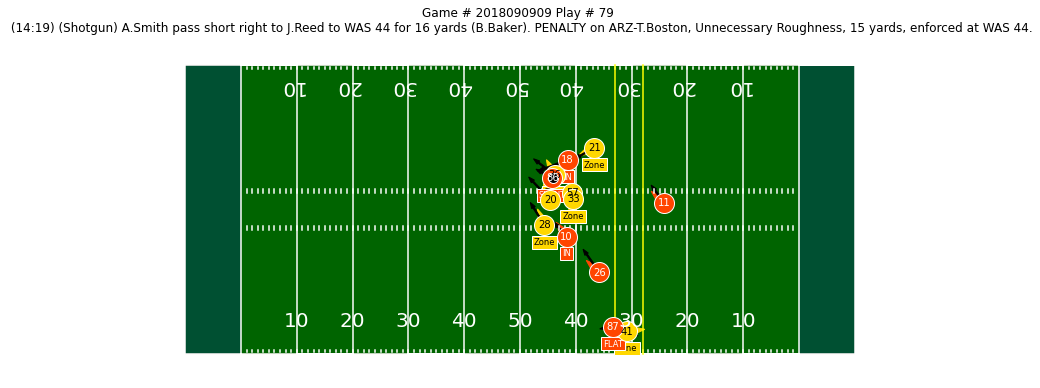

In [17]:
anim = animate_player_movement(weekData=weekFin, playId=79, gameId=2018090909)
writer = FFMpegWriter(fps=10)
anim.save('anim.mp4', writer=writer)

In [18]:
Video("anim.mp4")

# WR and TE Routes vs Different Coverages

Something to focus on is on player routes and quantifying their effectiveness against man vs zone coverages. Using the framework from above, I have a method to determine whether the corner closest to a receiver is playing in man vs zone (i.e. it doesn't generalize for the entire defense, since there are some hybrid defenses and whatnot).

What we need to do:

- Identify whether a route runner is lined up against a defender with a classification for man vs zone
- If they are, then find their outcome for the play
     - If they were targeted, if caught, and if caught then how many yards?
- Also identify players who maximize yards against man, players who maximize yards against zone
    - A step further: which routes maximize yardage vs coverages? How to adjust for potential outliers / "explosive plays"?
    - One option is to consider yard line of receiver where the ball is caught, and consider that the metric to use

In [19]:
weekFin['route'].unique()

array([nan, 'HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN',
       'CORNER', 'IN', 'ANGLE', 'POST', 'WHEEL'], dtype=object)

In [22]:
## Identify whether WR/TE is against a defender with man/zone
weekFin

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,frameId,team,gameId,playId,playDirection,route,oppMinDist,closestOpp(nflId),oppDir,oppX,oppY,mateMinDist,closestMate(nflId),mateX,mateY,diffDir,oppMateDistRatio,varX,varY,varS,oppVar,oppMean,mateVar,mateMean,oppDirVar,oppDirMean,meanOppMateDistRatio,varOppMateDistRatio,cluster,cluster_prob,coverage
0,2018-09-07T01:07:14.599Z,91.73,26.67,0.00,0.01,0.02,289.57,240.93,before_throw,310.0,Matt Ryan,2.0,QB,1,away,2018090600,75,left,NaN,6.100525,2558175.0,38.80,85.63,26.59,3.400235,2559033.0,33.29,43.92,202.13,0.110648,0.000009,0.000062,0.000000,0.000504,6.063867,0.000046,3.393964,50.527362,199.977273,0.109966,1.750028e-07,NaN,NaN,NaN
1,2018-09-07T01:07:14.599Z,88.89,36.47,0.01,0.01,0.01,105.63,66.66,before_throw,79848.0,Malcolm Jenkins,27.0,SS,1,home,2018090600,75,left,NaN,1.916899,2533040.0,193.97,90.78,36.15,5.867759,2552315.0,33.29,43.92,127.31,0.033043,0.000036,0.000189,0.000000,0.000025,1.918109,0.000972,5.882770,2637.883442,193.817273,0.033064,7.312639e-09,0.0,1.0,Zone
2,2018-09-07T01:07:14.599Z,91.35,44.16,0.02,0.03,0.01,290.45,16.86,before_throw,2495454.0,Julio Jones,11.0,WR,1,away,2018090600,75,left,HITCH,7.380474,2555383.0,110.32,84.00,43.49,8.030255,2533040.0,33.29,43.92,93.46,0.145538,0.000096,0.000147,0.000067,0.001877,7.415220,0.000221,8.025493,1942.248702,110.977273,0.146257,9.394571e-07,NaN,NaN,NaN
3,2018-09-07T01:07:14.599Z,86.31,22.01,0.09,0.42,0.01,70.12,168.91,before_throw,2495613.0,Corey Graham,24.0,FS,1,home,2018090600,75,left,NaN,4.983252,2555415.0,151.83,91.29,21.83,3.929377,2552689.0,33.29,43.92,17.08,0.080292,0.003216,0.000187,0.001645,0.002955,4.912147,0.005817,4.013412,463.282687,63.215455,0.079150,7.673017e-07,0.0,1.0,Zone
4,2018-09-07T01:07:14.599Z,90.78,36.15,0.00,0.00,0.00,257.61,193.97,before_throw,2533040.0,Mohamed Sanu,12.0,WR,1,away,2018090600,75,left,HITCH,1.916899,79848.0,66.66,88.89,36.47,8.030255,2495454.0,33.29,43.92,127.31,0.034171,0.000000,0.000016,0.000000,0.000025,1.918109,0.000221,8.025493,2637.883442,193.817273,0.034193,8.384209e-09,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
986017,2018-09-11T05:29:39.900Z,33.68,43.14,1.96,3.79,0.22,281.35,309.70,after_throw,2556277.0,Marqui Christian,41.0,SS,65,away,2018091001,4192,left,NaN,0.940479,2556885.0,314.39,33.02,43.81,2.323984,2558183.0,33.29,43.92,4.69,3.225815,0.277126,34.902151,1.649024,2.218413,2.991775,11.420737,5.478244,23325.734304,159.538750,0.512020,4.598862e-01,0.0,1.0,Zone
986018,2018-09-11T05:29:39.900Z,36.02,40.21,0.81,1.52,0.09,308.07,234.06,after_throw,2556593.0,Cory Littleton,58.0,ILB,65,away,2018091001,4192,left,NaN,3.967896,2550597.0,315.18,32.43,38.52,1.998650,2558183.0,33.29,43.92,81.12,0.725651,0.625229,2.031241,0.581810,1.129689,1.619296,4.014936,4.537267,10906.439354,117.217250,0.532592,6.819830e-01,NaN,NaN,NaN
986019,2018-09-11T05:29:39.900Z,33.02,43.81,2.63,4.57,0.27,183.83,314.39,after_throw,2556885.0,Jalen Richard,30.0,RB,65,home,2018091001,4192,left,SCREEN,0.940479,2556277.0,309.70,33.68,43.14,4.002249,2534241.0,33.29,43.92,4.69,1.078448,9.480825,2.817019,1.892552,10.442946,3.807975,3.161102,4.877536,5236.692195,104.892750,0.894473,3.891088e-01,NaN,NaN,NaN
986020,2018-09-11T05:29:39.900Z,34.13,40.86,0.15,0.72,0.02,6.17,267.87,after_throw,2558183.0,John Johnson,43.0,SS,65,away,2018091001,4192,left,NaN,2.892335,2550597.0,315.18,32.43,38.52,1.998650,2556593.0,33.29,43.92,47.31,0.528952,4.825613,3.195425,2.946383,7.387544,4.646112,5.305397,4.275220,9753.260261,117.056000,1.446592,2.560650e+00,0.0,1.0,Zone


In [44]:
## Get outcomes by play id
plays

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,playType,yardlineSide,yardlineNumber,offenseFormation,personnelO,defendersInTheBox,numberOfPassRushers,personnelD,typeDropback,preSnapVisitorScore,preSnapHomeScore,gameClock,absoluteYardlineNumber,penaltyCodes,penaltyJerseyNumbers,passResult,offensePlayResult,playResult,epa,isDefensivePI
0,2018090600,75,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,I_FORM,"2 RB, 1 TE, 2 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0.0,0.0,15:00:00,90.0,NaN,NaN,C,10,10,0.261827,False
1,2018090600,146,(13:10) M.Ryan pass incomplete short right to ...,1,1,10,ATL,play_type_pass,PHI,39,SINGLEBACK,"1 RB, 1 TE, 3 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0.0,0.0,13:10:00,49.0,NaN,NaN,I,0,0,-0.372360,False
2,2018090600,168,(13:05) (Shotgun) M.Ryan pass incomplete short...,1,2,10,ATL,play_type_pass,PHI,39,SHOTGUN,"2 RB, 1 TE, 2 WR",6.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0.0,0.0,13:05:00,49.0,NaN,NaN,I,0,0,-0.702779,False
3,2018090600,190,(13:01) (Shotgun) M.Ryan pass deep left to J.J...,1,3,10,ATL,play_type_pass,PHI,39,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,5.0,"4 DL, 1 LB, 6 DB",SCRAMBLE_ROLLOUT_LEFT,0.0,0.0,13:01:00,49.0,NaN,NaN,C,33,33,3.047530,False
4,2018090600,256,(10:59) (Shotgun) M.Ryan pass incomplete short...,1,3,1,ATL,play_type_pass,PHI,1,SHOTGUN,"2 RB, 3 TE, 0 WR",8.0,6.0,"6 DL, 3 LB, 2 DB",TRADITIONAL,0.0,0.0,10:59:00,11.0,NaN,NaN,I,0,0,-0.842272,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19234,2018122200,2300,(7:53) J.Johnson pass incomplete short left [K...,3,2,5,WAS,play_type_unknown,WAS,31,SINGLEBACK,"1 RB, 1 TE, 3 WR",7.0,NaN,"2 DL, 4 LB, 5 DB",NaN,NaN,NaN,NaN,NaN,DH,TEN 24,I,0,5,0.848703,False
19235,2018122200,3177,(6:53) (Shotgun) B.Gabbert pass incomplete sho...,4,3,7,TEN,play_type_unknown,WAS,37,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,NaN,"2 DL, 4 LB, 5 DB",NaN,NaN,NaN,NaN,NaN,DH,WAS 31,I,0,5,1.227695,False
19236,2018122201,566,(5:32) (Shotgun) P.Rivers pass deep right to K...,1,3,4,LAC,play_type_unknown,LAC,49,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,NaN,"1 DL, 5 LB, 5 DB",NaN,NaN,NaN,NaN,NaN,OPI,LAC 13,C,27,-10,-0.720168,False
19237,2018122201,1719,(1:08) P.Rivers pass incomplete deep middle to...,2,3,1,LAC,play_type_unknown,LAC,48,SINGLEBACK,"1 RB, 1 TE, 3 WR",7.0,NaN,"2 DL, 3 LB, 6 DB",NaN,NaN,NaN,NaN,NaN,DPI,BAL 23,I,0,15,1.336078,True
